## Read datasets

In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import StratifiedKFold,train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
import pickle
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# read dataset
df = pd.read_csv('../data/Loan_Default.csv')
df.drop(columns=['ID','year','Interest_rate_spread','Upfront_charges','rate_of_interest'],inplace=True)
df = df.sample(20000,random_state=0)
X = df.drop(columns='Status')
y = df['Status']

## Preprocessing strategy

In [ ]:
binary_cat_ftrs = ['Credit_Worthiness', 'open_credit', 'business_or_commercial', 'interest_only', 'lump_sum_payment', 'construction_type', 'Secured_by', 'co-applicant_credit_type', 'Security_Type']
ordinal_ftrs = ['total_units','age'] 
ordinal_cats = [['1U', '2U', '3U', '4U','missing'], 
                ['<25','25-34','35-44','45-54','55-64','65-74','>74','missing']]
onehot_ftrs = ['loan_limit','approv_in_adv','Gender','loan_type','loan_purpose','Neg_ammortization','occupancy_type','credit_type','submission_of_application','Region']

categorical_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('ord_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(categories=ordinal_cats,handle_unknown='use_encoded_value', unknown_value=-1))
])

labelEncoding_transformer = OrdinalEncoder()

transformer = ColumnTransformer(
transformers=[
    ('cat', categorical_transformer, onehot_ftrs),
    ('ord', ordinal_transformer, ordinal_ftrs),
    ('bi_cat',labelEncoding_transformer,binary_cat_ftrs)
], remainder='passthrough')

final_standard = StandardScaler()

preprocessor = Pipeline(steps=[
    ('transformer', transformer),
    ('final_standard', final_standard)
])

In [ ]:
# missing values in continuous features
X_transfomed = preprocessor.fit_transform(X)
df=pd.DataFrame(X_transfomed,columns=preprocessor.get_feature_names_out())
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

fraction of missing values in features:
remainder__term              0.00030
remainder__property_value    0.10220
remainder__income            0.06025
remainder__LTV               0.10220
remainder__dtir1             0.16155
dtype: float64


In [ ]:
# missing values patterns
mask = df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].isnull()

unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
print(unique_rows.shape) 
for i in range(len(counts)):
    print(unique_rows[i],counts[i])

(7, 5)
[False False False False False] 16749
[False False  True False False] 17
[False False  True False  True] 1187
[False  True False  True  True] 2040
[False  True  True  True  True] 1
[ True False False False False] 3
[ True  True False  True  True] 3


## Build the model pipeline

In [ ]:
def reduced_feature_logistic(X_train, y_train, X_test, y_test, param_grid,random_state):
    
    # find all unique patterns of continuous missing value in test set
    continuous_columns = X_test.select_dtypes(include=['float64', 'int64']).columns
    mask = X_test.isnull()

    categorical_columns = X_test.select_dtypes(include=['object', 'category']).columns
    mask[categorical_columns] = False  

    mask[continuous_columns] = X_test[continuous_columns].isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    best_models = []
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): 

                sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_train = sub_X_train.dropna()
        sub_Y_train = y_train.loc[sub_X_train.index]
        
        kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=i)
        clf = LogisticRegression()
        pipe = make_pipeline(preprocessor, clf)

        grid =RandomizedSearchCV(pipe, param_grid, scoring='accuracy', cv=kf, return_train_score=True, n_jobs=-1, verbose=True,random_state=random_state)

        grid.fit(sub_X_train,sub_Y_train)
        best_model = grid.best_estimator_
        best_models.append(best_model)
        sub_y_test_pred = best_model.predict(sub_X_test)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred,columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        print('num of sample: ', len(sub_y_test_pred))
        print(' accuracy score:',accuracy_score(sub_y_test,sub_y_test_pred))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
               
 
    return all_y_test_pred,best_models,unique_rows

In [6]:
# Parameter grid for hyperparameter tuning
param_grid = {
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__penalty': [None,'l1', 'l2'],       
    'logisticregression__solver': ['saga'],           
    'logisticregression__max_iter': [500]  
}



y_preds = []
models = []
test_sets = []
unique_rows_record = []
for random_state in range(5):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state)

    all_y_test_pred,best_models,unique_rows = reduced_feature_logistic(X_train, y_train, X_test, y_test, param_grid, random_state)

    test_sets.append([X_test,y_test])
    unique_rows_record.append(unique_rows)
    models.append(best_models)
    y_preds.append(all_y_test_pred)


there are 5 unique missing value patterns.
working on unique pattern 0
Fitting 4 folds for each of 9 candidates, totalling 36 fits
num of sample:  3361
 accuracy score: 0.8503421600714073
working on unique pattern 1
Fitting 4 folds for each of 9 candidates, totalling 36 fits
num of sample:  2
 accuracy score: 0.5
working on unique pattern 2
Fitting 4 folds for each of 9 candidates, totalling 36 fits
num of sample:  234
 accuracy score: 0.8803418803418803
working on unique pattern 3
Fitting 4 folds for each of 9 candidates, totalling 36 fits
num of sample:  402
 accuracy score: 1.0
working on unique pattern 4
Fitting 4 folds for each of 9 candidates, totalling 36 fits
num of sample:  1
 accuracy score: 1.0
there are 6 unique missing value patterns.
working on unique pattern 0
Fitting 4 folds for each of 9 candidates, totalling 36 fits
num of sample:  3340
 accuracy score: 0.854191616766467
working on unique pattern 1
Fitting 4 folds for each of 9 candidates, totalling 36 fits
num of sam

In [ ]:
file = open('../results/reduced_feature_logistic.save', 'wb')
pickle.dump((y_preds, models, test_sets, unique_rows_record), file)
file.close()

## Load and interpret the model

In [ ]:
file = open('../results/reduced_feature_logistic.save', 'rb')
y_preds, models, test_sets, unique_rows_record = pickle.load(file)
file.close()

In [9]:
accs = []
f1s = []
recalls = []
precisions = []


for y_pred,test_set in zip(y_preds,test_sets):
    _,y_test = test_set
    order_y_test = y_test.sort_index()
    accs.append(accuracy_score(order_y_test,y_pred))
    f1s.append(f1_score(order_y_test,y_pred))
    recalls.append(recall_score(order_y_test,y_pred))
    precisions.append(precision_score(order_y_test,y_pred))

In [10]:
print(f"mean of accuracy score: {np.mean(accs)},    standard deviation of accuracy score: {np.std(accs)}")
print(f"mean of f1 score: {np.mean(f1s)},     standard deviation of f1 score: {np.std(f1s)}")
print(f"mean of recall score: {np.mean(recalls)},     standard deviation of recall score: {np.std(recalls)}")
print(f"mean of precision score: {np.mean(accs)},     standard deviation of precision score: {np.std(precisions)}")

mean of accuracy score: 0.867,    standard deviation of accuracy score: 0.003297726489568227
mean of f1 score: 0.6485620262538616,     standard deviation of f1 score: 0.01024923815573843
mean of recall score: 0.49847715736040604,     standard deviation of recall score: 0.010686454714266628
mean of precision score: 0.867,     standard deviation of precision score: 0.01092101490573547


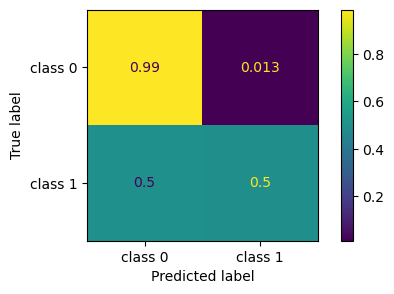

In [ ]:
X_test,y_test = test_set
cm = confusion_matrix(order_y_test,y_pred)
disp = ConfusionMatrixDisplay((cm.T/np.sum(cm.T,axis=0)).T,display_labels=['class 0', 'class 1'])
fig, ax = plt.subplots(figsize=(6,3))
disp.plot(ax=ax)
plt.show()

#### Permutation feature importance

In [ ]:
def get_sub_set(X_test,y_test,unique_row):
    mask = X_test.isnull()
    sub_X_test = pd.DataFrame()
    sub_y_test = pd.Series(dtype=float)
    for j in range(len(mask)): 
        row_mask = np.array(mask.iloc[j])
        if np.array_equal(row_mask, unique_row): 

            sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])
            sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])
    return sub_X_test, sub_y_test

In [13]:
# use the one of models to check feature importances
np.random.seed(42)
i, j = 0, 0
X_test,y_test = test_sets[i]
unique_row = unique_rows_record[i][j]
model = models[i][j]

ftr_names = X_test.columns
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])


sub_X_test,sub_y_test = get_sub_set(X_test,y_test,unique_row)
sub_X_test = sub_X_test.dropna(axis=1)
test_score = model.score(sub_X_test,sub_y_test)
print(i,j,'test score = ',test_score)
print('test baseline = ',np.sum(sub_y_test == 0)/len(sub_y_test))
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        sub_X_test_shuffled,sub_y_test = get_sub_set(X_test_shuffled,y_test,unique_row)
        sub_X_test_shuffled = sub_X_test_shuffled.dropna(axis=1)
        acc_scores.append(model.score(sub_X_test_shuffled,sub_y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores
    scores[i] = acc_scores

0 0 test score =  0.8495710784313726
test baseline =  0.8360906862745098
shuffling loan_limit
   shuffled test score: 0.848 +/- 0.001
shuffling Gender
   shuffled test score: 0.849 +/- 0.0
shuffling approv_in_adv
   shuffled test score: 0.849 +/- 0.001
shuffling loan_type
   shuffled test score: 0.849 +/- 0.001
shuffling loan_purpose
   shuffled test score: 0.847 +/- 0.001
shuffling Credit_Worthiness
   shuffled test score: 0.849 +/- 0.0
shuffling open_credit
   shuffled test score: 0.85 +/- 0.0
shuffling business_or_commercial
   shuffled test score: 0.85 +/- 0.001
shuffling loan_amount
   shuffled test score: 0.849 +/- 0.001
shuffling term
   shuffled test score: 0.85 +/- 0.0
shuffling Neg_ammortization
   shuffled test score: 0.842 +/- 0.002
shuffling interest_only
   shuffled test score: 0.85 +/- 0.0
shuffling lump_sum_payment
   shuffled test score: 0.831 +/- 0.002
shuffling property_value
   shuffled test score: 0.839 +/- 0.003
shuffling construction_type
   shuffled test score: 

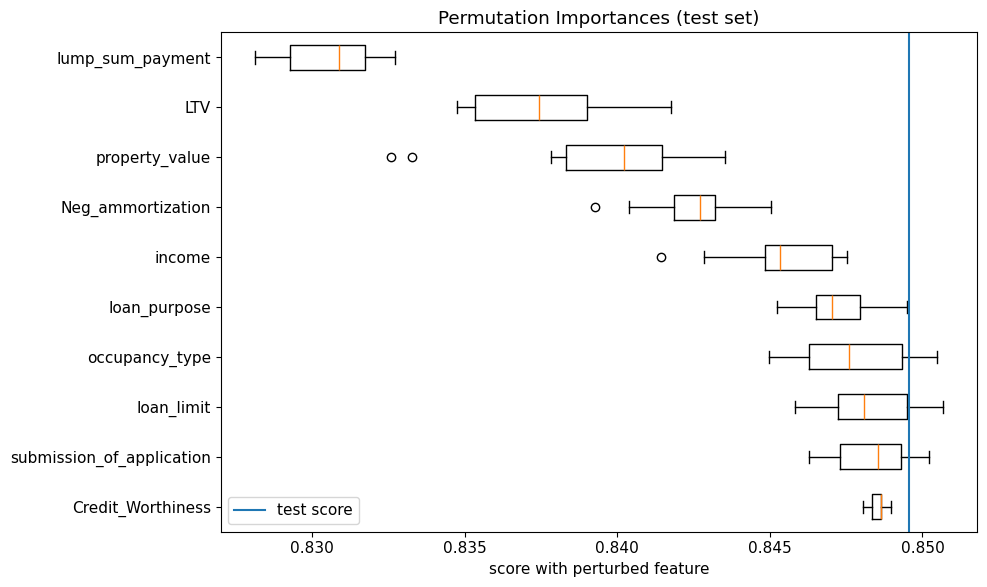

In [14]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[:10][::-1]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10,6))
plt.boxplot(scores[sorted_indcs].T,tick_labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

#### coefficient of scaled data in Logisitic Regression

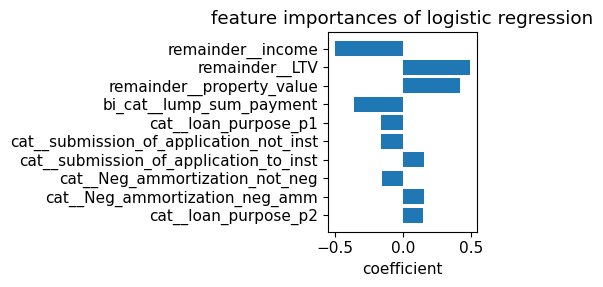

In [15]:

coefs = model[-1].coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))
feature_names = model[:-1].get_feature_names_out()
plt.figure(figsize=(5,3))
plt.rcParams.update({'font.size': 11})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('feature importances of logistic regression')
plt.tight_layout()

plt.show()